# Class + related functions to work with entire Micrometeoroid Impact Catalog

Written by Sophie Hourihane - based on work by Ira Thorpe and Nicole Pagane


8/1/2018

In [1]:
# import relevant libraries
import numpy as np
import os
import re
import pathlib
import healpy as hp
import pickle
import matplotlib.pyplot as plt
import datetime
from impactClass import impactClass
from impactClass import impactClassList
import copy
from scipy.optimize import curve_fit
import pandas as pd
%matplotlib inline

def getGRSSegments(filenames, grs = 1):
    # Get list of segment times
    regex = r'(\d*)_grs%i.*'%(grs)
    segments = []
    for f in filenames:
        if re.match(regex, f):
            segments.append(int(re.findall(regex, f)[0]))
    return segments

/Applications/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Initialize Environment
Assuming your directory structure is correct & you have the pickle files, everything should work out nicely

In [2]:
# setup directory structure
p = pathlib.PurePath(os.getcwd())
BASE_DIR = str(p.parent)
dataDir = '/data'

#### Loading Impact Class List
This is a class of impacts and related functions. It seemed like a good idea but I really just needed a sorting function for a list
- `grs`: int (1 or 2) Which GRS we are looking at
    - default: 1
- `getValid`: Bool, Only load impacts that have not been vetoed
    - default: True
- `BASE_DIR`: the base directory where /Analysis lives
    - default: None, finds parent of cwd
- `dataDir`: directory inside of /Analysis where all data lives
- `directory`: the directory inside /Analysis where the pickle files we are trying to load live
    - default: /data/ONLY_IMPACTS

In [3]:
# IRA
# I think the only change to be made is the directory, 
# for you it should be directory = '/data'
# This takes a little bit to load, ~ 1 minute, 
# do NOT try to load every segment, just the impacts
impactList = impactClassList(grs = 1, getValid = True, BASE_DIR = BASE_DIR, 
                             dataDir = dataDir, include_marginal = True,
                             directory = dataDir + '/ONLY_IMPACTS')


Reading through pickle files


### Loading Population model data
Populations models made by Petr
- `modelDir`: full path to population models
- `pop_type`: string, one of ['JFC', 'HTC', 'AST', 'OCC', 'Uniform']
- `usePtot`: Bool, whether to interpolate with momentum as well, should always be True

In [4]:
from populationClass import population as pop
modelDir = BASE_DIR + dataDir + '/models'
usePtot = True  # Old boolean for ignoring momentum
pop_names = ['JFC', 'HTC', 'AST', 'OCC', 'Uniform']
populations = []
# Takes about 30 seconds to read all populations in 
for p in pop_names:
    print(p)
    populations.append(pop(modelDir = modelDir, pop_type = p, usePtot = True))

JFC
HTC
AST
OCC
Uniform


### Plots

/Applications/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


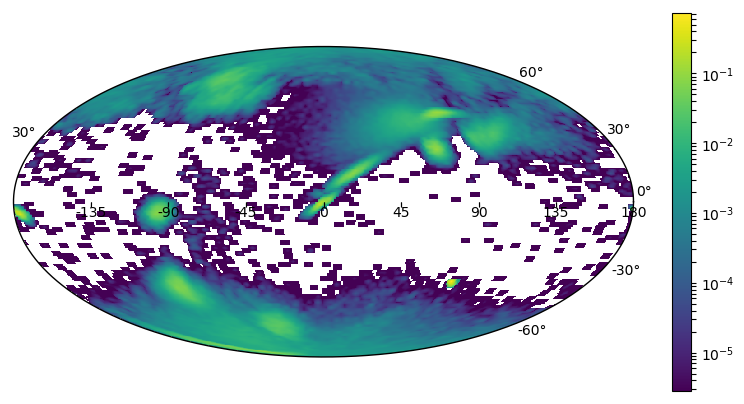

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


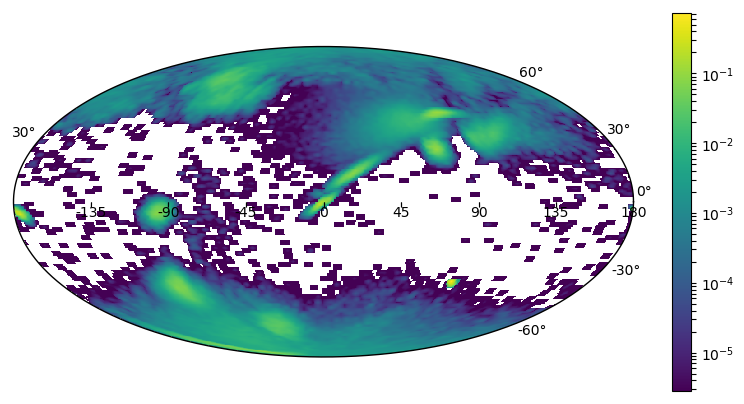

In [5]:
def plotSkyMap(self, percent_sky = 0.1, scale = 'log'):
    from astropy.coordinates import SkyCoord
    from astropy.io import fits
    from astropy import units as u
    import ligo.skymap.plot
    import matplotlib as mpl


    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax = plt.axes(
            projection = 'geo degrees mollweide')

    # Copy shape of healPix
    healPix_sun = self.impact_list[0].healPix_sun * 0

    count = 0
    
    minimum = 1
    maximum = 0
    for i, impact in enumerate(self.impact_list):
        if impact.skyArea_sun > percent_sky * 41253:
            continue
            
        minimum = min(minimum, min(impact.healPix_sun[impact.healPix_sun > 0]))
        maximum = max(maximum, max(impact.healPix_sun))

    norm = mpl.colors.LogNorm(vmin = minimum, vmax = maximum)
    for i, impact in enumerate(self.impact_list):
        
        if impact.skyArea_sun > percent_sky * 41253:
            continue
        count += 1
        healPix_sun += impact.healPix_sun
        #cax = ax.imshow_hpx(impact.healPix_sun, cmap = 'rainbow', norm = norm, alpha = 1) 

    
    if 'log' in scale:
        minimum = min(healPix_sun[healPix_sun > 0])
        norm = mpl.colors.LogNorm(vmin = minimum, vmax = max(healPix_sun))
    else:
        norm = mpl.colors.Normalize(vmin = min(healPix_sun), vmax = max(healPix_sun))

    cax = ax.imshow_hpx(healPix_sun, cmap = 'viridis', norm = norm) 
    fig.colorbar(cax)
    return fig

plotSkyMap(impactList, percent_sky = 0.1, scale = 'log')

    

#### Plot Power Law
Plots and fits a power law given a parameter like 'Ptot', 'lat', 'lon' etc
- `param` : string, which parameter goes on the x axis 
    - default: 'Ptot'
- `credibles`: List of floats < 1, What credible intervals to show
    - default: [0.9]
- `weight`: Bool, whether to weight fit on errors
    - default: True
- `drop_max`: Bool, whether to drop the maximum impact in the fit
    - default: True

In [14]:

def plotPowerLaw(self, param = 'Ptot', credibles = [0.9], weight = True,
                     drop_max = True):
        """
        self = impactClassList instance
        param = parameter plotted on x we fit for
        credibles = credible intervals we want on the plot (list type)
        weight = boolean, whether we want the plot weighted
        drop_max = Boolean, wheteher to drop the max momentum in our impact list
        """
        error_color = plt.cm.PuBu(np.linspace(.5, 1, len(credibles)))
        fit_color = "#e86e66"
        data_color = '#ffd27a'#'#92cac6'#"#6b9bb9"
        import matplotlib as mpl
        mpl.rcParams['lines.linewidth'] = 4
        mpl.rcParams['font.size'] = 15
        mpl.rcParams['font.family'] = 'sans-serif'
        
        fig, ax = plt.subplots(figsize = (10,10))

        # Sort data
        sortlist = sorted(self.impact_list, key=lambda x: x.getMedian(param))
        # Drops the largest number
        shift = 0
        if drop_max:
            imp_max = sortlist[-1]
            sortlist = sortlist[:-1]
            shift = 1
            # Replot the highest point
            ax.scatter(imp_max.getMedian('Ptot'), 1, color = data_color)

        xdata = np.asarray([i.getMedian(param) for i in sortlist]) #makeArray(sortlist, param, np.median))
        ydata = np.arange(1 + shift, len(sortlist) + 1 + shift, 1.0)[::-1]


        # Plot the data
        ax.scatter(xdata, ydata, color = data_color, zorder = 10,
                   label = 'Median Momentum', marker = 'o', s = 50)
        lines = []
        
        
        for i, credible in enumerate(credibles):
            # Get Credible Intervals and stdev
            cred_up, cred_down, stdev, median = self.getCredibleIntervals(sortlist, param,
                                                                          credible, getMedian = True)

            #Get power Law fit
            if weight:
                popt, pcov = self.fitPowerlaw(sortlist, param, sigma = 1 / (cred_up - cred_down))
            else:
                popt, pcov = self.fitPowerlaw(sortlist, param, sigma = None)

            print('Optimized: a = ', popt[0], 'b =', popt[1] )

            # Sets up points to plot for fit
            plot_x = np.logspace(np.log10(min(xdata)), np.log10(max(xdata)), 1000)

            if credible == .90:
                ax.plot(plot_x, self.power_func(plot_x, *popt),
                        color = fit_color,
                        label = r'Data Fit: %1.2f$(\frac{P}{[\mu N s]})^{%1.2f}$'%(popt[0], popt[1]))

            # Credible Intervals
            ax.errorbar(xdata, ydata, xerr = [median - cred_down, cred_up - median],
                 fmt = 'o',
                        color = 'none',
                        ecolor = error_color[i], label = '%i%% Credible'%(credible * 100),
                 alpha = .75)
            
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel('Cumulative Number of Impacts')

        if param == 'Ptot':
            ax.set_xlabel('$p_{tot}\,[\mu N s]$')
        else:
            ax.set_xlabel(param)


        ax.legend()
        return fig, ax
        
        
        

Optimized: a =  44.77255883069782 b = -0.7286758133308445
Optimized: a =  44.764460011758054 b = -0.7264843226558738
Optimized: a =  46.491370223301566 b = -0.7310093871147543
Optimized: a =  56.21156275121724 b = -0.9643073119176843
Optimized: a =  56.68466021335748 b = -0.9663819716013431
Optimized: a =  59.861887522407436 b = -0.9722099381951311


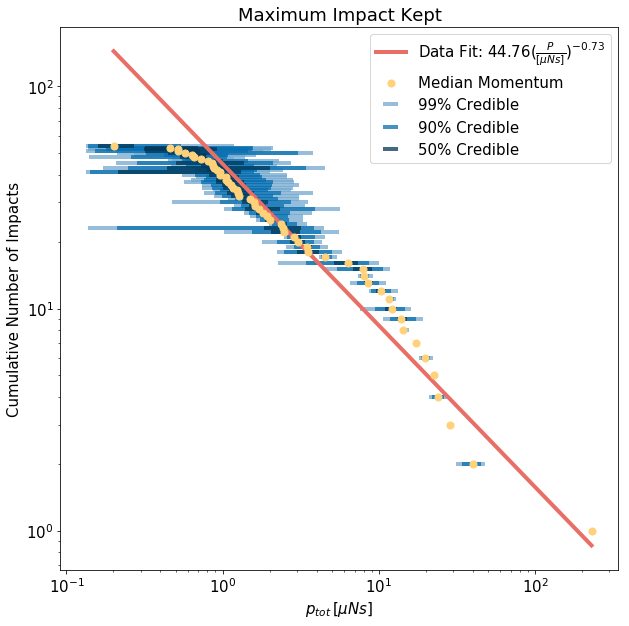

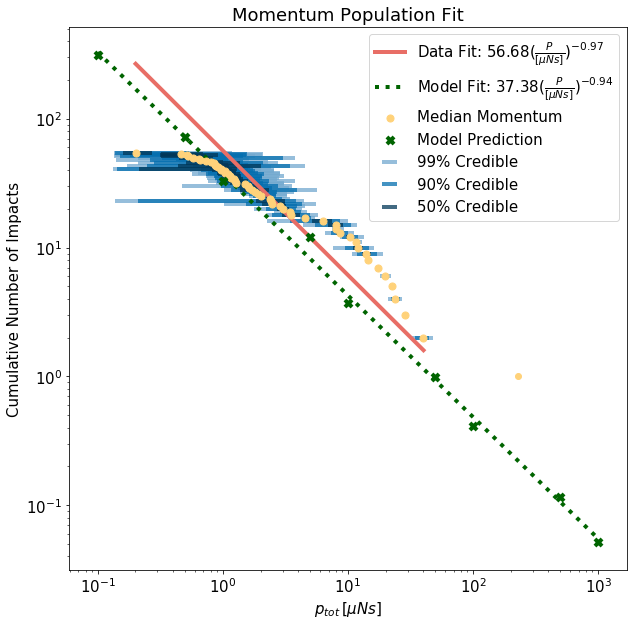

In [15]:
# Without dropping the maxiumum impact
fig, ax = plotPowerLaw(impactList, param = 'Ptot', credibles = [0.99, 0.9, 0.5], weight = True, 
                                  drop_max = False)
ax.set_title('Maximum Impact Kept')


# With dropping the maximum impact
fig, ax = impactList.plotPowerLaw(param = 'Ptot', credibles = [0.99, 0.9, 0.5], weight = True, 
                                   drop_max = True)
ax.set_title('Maximum Impact Dropped')

# We can add the sum of the models line but we need to load the correct data
def lin_func(x, m, b):
    return m * x + b
def power_func(x, a, b):
    return a * (x ** b)

sum_flux = np.zeros(9)
for p in populations:
    # We don't want to include uniform because its made up
    if p.pop_type not in ['JFC', 'HTC', 'AST', 'OCC']:
        continue
        
    # Groupby Momentum
    grouped = p.df.groupby(['Ptot'])['flux'].sum().reset_index()
    # Make Cumulative
    for i in range(len(grouped.index)):
        grouped['flux'][i] = np.sum(grouped['flux'][i:])
        sum_flux[i] += np.sum(grouped['flux'][i:])

# Surface rea of the LPF
Area_SC = 10.377479175382778
# Cross sectional area of the LPF
cross_section_SC = 2
total_time = 168 #days
    
# Fits the model
time = total_time * 24 * 60 * 60 # seconds

# Make momentum array
xdata = np.asarray(grouped['Ptot'].values)
ydata = np.asarray(sum_flux * time * cross_section_SC)
popt, pcov = curve_fit(lin_func, np.log(xdata), np.log(ydata), p0 = (1, 1))
b = popt[0]
a = np.exp(popt[1])
popt = [a, b]
# Sets up points to plot for fit
plot_x = np.logspace(np.log10(min(xdata)), np.log10(max(xdata)), 1000)
        
ax.plot(plot_x, power_func(plot_x, *popt),
        color = 'DarkGreen',#'#92cac6',
        linestyle = ':',
        label = r'Model Fit: %1.2f$(\frac{P}{[\mu N s]})^{%1.2f}$'%(popt[0], popt[1]))

ax.scatter(grouped['Ptot'], ydata, color = 'DarkGreen',#'#92cac6', 
           marker = 'x', s = 50, zorder = 10,
           label = 'Model Prediction' )

ax.set_title('Momentum Population Fit')
ax.legend()


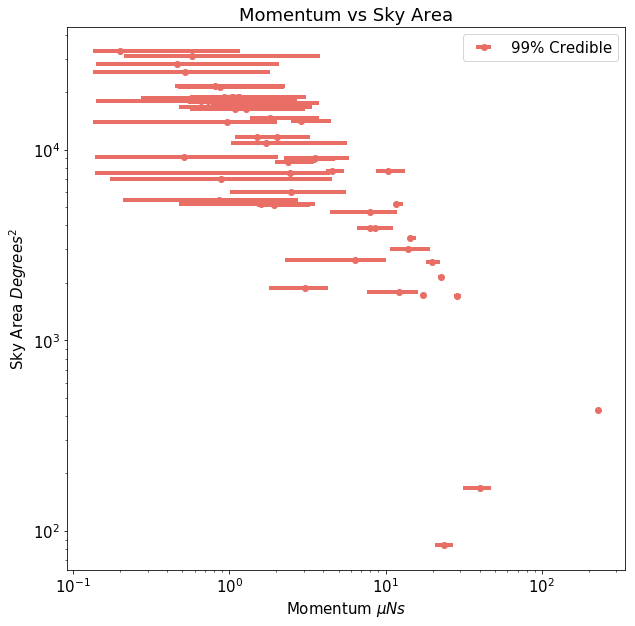

In [7]:
fig = impactList.plotMomSkyArea(credible = 0.99);


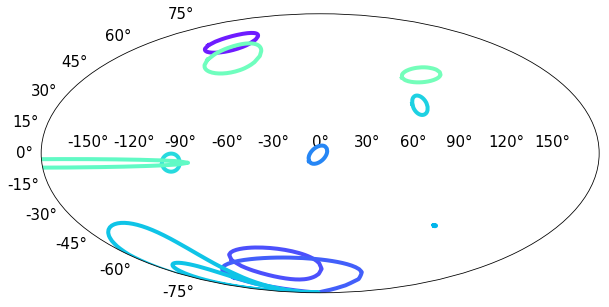

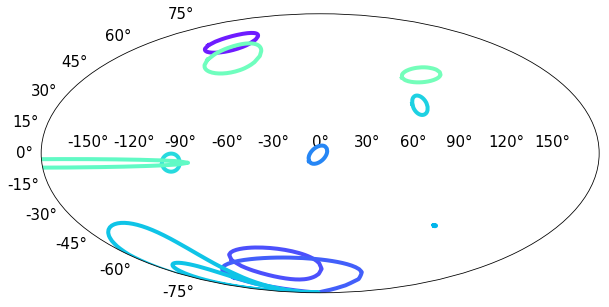

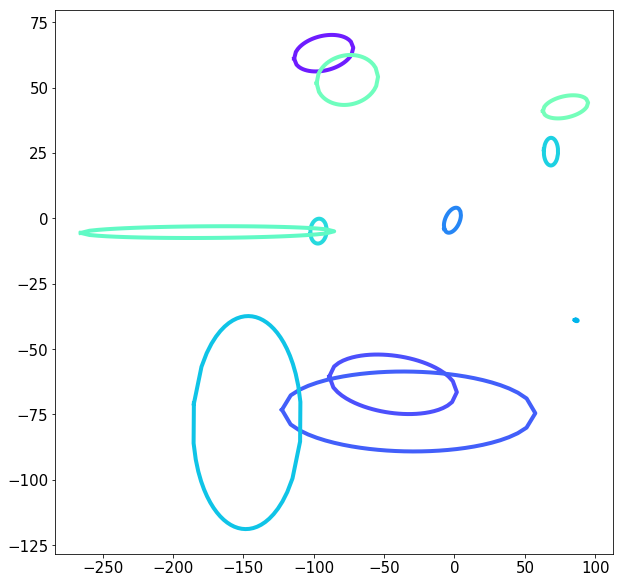

In [8]:
def getXYEllipse(center, x_span, y_span, angle):
    
    x_points = np.linspace(-x_span, x_span, 30)
    
    #Get upper half of ellipse
    #       -  
    #   -       -
    # -            -
    y_list = []
    for x in x_points:
        y = np.sqrt((y_span ** 2) * (1 - (x / x_span) **2))
        y_list.append(y)
        
        
    # Create List
    x_list = np.asarray(list(x_points) + list(x_points[::-1]))
    minus_y = [-1 * y for y in y_list]
    y_list = np.asarray(y_list + minus_y)
        
    #Rotate
    x_new = [x_list[i] * np.cos(angle) - y_list[i] * np.sin(angle) 
             for i in range(len(x_list))]
    y_new = [x_list[i] * np.sin(angle) + y_list[i] * np.cos(angle) 
             for i in range(len(x_list))]
    
    x_new += center[0]
    y_new += center[1]
    
    return x_new, y_new


from  matplotlib.patches import Ellipse
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import ligo.skymap.plot
import healpy as hp


def getEllipse(impact, percent_sky = .1, getPoints = False, rads = False):
    if impact.skyArea_sun > percent_sky * 41253: #or impact.skyArea_sun == 0:
        if impact.skyArea_sun == 0:
            print(impact.gps, impact.N, len(impact.lon), impact.skyArea)
        #print(impact.skyArea_sun, '>',  percent_sky * 41253)
        return None, None
        
    if rads:
        lons = np.deg2rad(impact.lon_sun) #getParam('lon')
        lats = np.deg2rad(impact.lat_sun) #getParam('lat')
    else:
        lons = impact.lon_sun#getParam('lon')
        lats = impact.lat_sun#getParam('lat')


    x2 = max(lons)
    x1 = min(lons)
    y2 = max(lats)
    y1 = min(lats)

    y_length = (y2 - y1) / 2
    x_length = (x2 - x1) / 2
    
    avg_x = sum(lons) / len(lons)
    avg_y = sum(lats) / len(lats)
    x_diff = [lon - avg_x for lon in lons]
    y_diff = [lat - avg_y for lat in lats]

    x_diff_squared = [element**2 for element in x_diff]
    slope = sum(x * y for x,y in zip(x_diff, y_diff)) / sum(x_diff_squared)
    angle = np.arctan(slope)
    
    if not rads:
        angle = np.rad2deg(angle)
    
    if getPoints:
        x, y = getXYEllipse([avg_x, avg_y], x_length / 2, y_length / 2, angle)
        return x, y
    else:
        ells = (Ellipse((avg_x, avg_y), 
                 x_length, y_length, angle, 
                 faceColor = 'none', edgeColor = 'indianRed'))
    return ells


#fig1, ax1 = plt.subplots(figsize = (8,8))
#ax1.set_ylim(-90, 90)
#ax1.set_xlim(-180, 180)

def plotEllipse(scatter = False):
    fig, ax = plt.subplots(figsize = (10,10), 
                       subplot_kw={'projection': 'mollweide'})
    
    fig2, ax2 = plt.subplots(figsize = (10,10))
    colors = plt.cm.rainbow(np.linspace(0, 1, 2 * len(impactList.impact_list)))
    for i, impact in enumerate(impactList.impact_list):

        x, y = getEllipse(impact, getPoints = True, rads = True, percent_sky = 0.05)
        if x is None:
            continue

        ax.plot(x, y, color = colors[i + 1], label = impact.gps)
        if scatter:
            ax.scatter(np.deg2rad(impact.lon_sun), np.deg2rad(impact.lat_sun), 
                       color = colors[i + 1])
        ax2.plot(np.rad2deg(x), np.rad2deg(y), 
                 color = colors[i + 1], label = impact.gps)
        
    return fig
        
plotEllipse(scatter = False)


Loading Valid Times
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


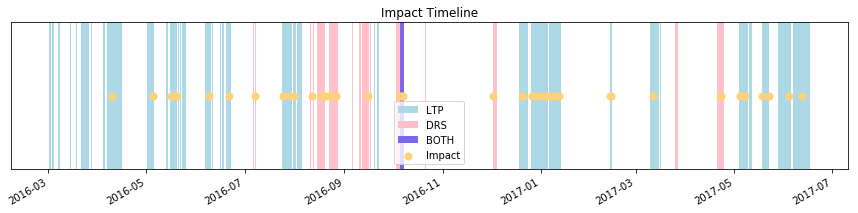

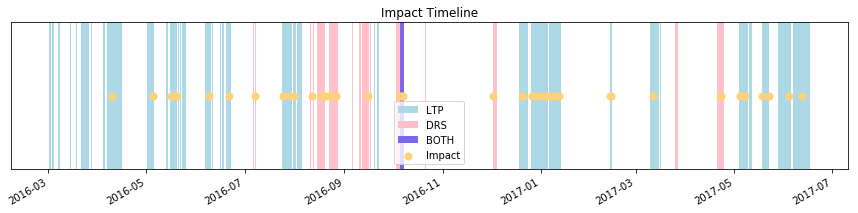

In [10]:
def getisGlitch(segment, df_veto):
    try:
        index = df_veto.index[df_veto['segment'] == int(segment)][0]
    except IndexError:
        # if not in the list, its not an Impact
        return False
    else:
        return df_veto['isGlitch'].values[index]

def getSearchTimes():
    search_times = pd.read_csv(BASE_DIR + '/scripts/segment_list_NEW.txt',
                               #dataDir + '/keyansegments.txt', 
                               #'/segment_list_NEW.txt',
            header = 'infer', delim_whitespace = True)
    
    return search_times

def getisValidSearch(segment, search_times):
    # search_times = pd.read_csv(BASE_DIR + dataDir + '/segment_list_NEW.txt',
    #        header = 'infer', delim_whitespace = True)
    try:
        index = search_times.index[search_times['segment'] == int(segment)][0]
    except IndexError:
        return False
    else:
        return True
    
def getisValidSearch_old(segment):
    search_times = pd.read_csv(BASE_DIR + dataDir + '/segment_list.txt',
            header = None, names = ['segment'], delim_whitespace = True)
    try:
        index = search_times.index[search_times['segment'] == int(segment)][0]
    except IndexError:
        return False
    else:
        return True


def isValid(segment, df_veto, search_times):
    # Both checks if the time searched is valid as well as 
    # if the time is a glitch

    if getisValidSearch(segment, search_times) and not getisGlitch(segment, df_veto):
        return True

    # If it's not in the segment list then its not a good segment
    return False

def get_start_stop(segments, seg_lens = None):
    segments = np.asarray(segments)
    sort = segments.argsort()
    segments = segments[sort]
    
    if seg_lens is not None:
        seg_lens = np.asarray(seg_lens)
        seg_lens = seg_lens[sort]

    start_stop = []
    i = 0
    while i < len(segments):
        start = segments[i]
        stop = 0
    
        count = 1
        while (stop == 0 and (i + count < len(segments))):
            if seg_lens is None:
                if start + 1648 * count + 5 > segments[i + count]:
                    count += 1
                else:
                    stop = segments[i + (count - 1)]
            else:
                if start + np.sum(seg_lens[i:(i + count)]) > segments[i + count]:
                    count += 1
                else:
                    stop = segments[i + (count - 1)]
                    
        if (i + count >= len(segments)):
            stop = segments[i + (count - 1)]
    
        if start == stop:
            if seg_lens is None:
                stop = start + 1648
            else:
                stop = start + seg_lens[i]
        
        start_stop.append([start, stop])
    
        i += count
    return start_stop

def timeline(self, dataDir  = dataDir, timeDir = BASE_DIR + '/data/observed_times',
             filenames = ['DRSlistDec.txt', 'LTPCMNTlist.txt', 'LTPlist2.txt'],
             segments = None):

    #import datetime
    #import time
    from astropy.time import Time
    
    #segments = np.loadtxt(BASE_DIR + dataDir + '/' + segment_file)
    
    def formatTime(gps):
        t0 = Time(gps, format='gps')
        t0 = Time(t0, format='iso')
        return t0.datetime
    
    print("Loading Valid Times")
    
    fig, ax = plt.subplots(figsize = (15, 3))
    ax.set_title('Impact Timeline')
    ax.yaxis.set_ticks_position('none') 

    regex = r'g_(\d+)_(\d+).tar.gz'
    j = 0
    colors = ['r', 'b', 'g']
    
    search_times = getSearchTimes()
    
    
    LTP = search_times[search_times['control'] == 'LTP'].reset_index()
    DRS = search_times[search_times['control'] == 'DRS'].reset_index()
    BOTH = search_times[search_times['control'] == 'BOTH'].reset_index()
    
    controls = [LTP, DRS, BOTH]
    
    # Plot segments
    
    for c in controls:
        print(type(c))
        name = c['control'].values[0]
        if name == 'LTP':
            color = 'lightblue'
        elif name == 'DRS':
            color = 'pink'
        else:
            color = 'mediumslateblue'
            
        start_stop = get_start_stop(c['segment'], seg_lens = c['length'])
        
        for i, ss in enumerate(start_stop):
            t0 = formatTime(ss[0])
            t1 = formatTime(ss[1])
                
            if i == 0:
                ax.axvspan(t0, t1, facecolor = color, alpha = 1, 
                           label = name)
            else:
                ax.axvspan(t0, t1, facecolor = color, alpha = 1)

    #Plot impacts
    for i, impact in enumerate(self.impact_list):
        if i == 0: 
            ax.scatter(formatTime(impact.gps), .5, color = '#ffd27a', 
                       label = 'Impact', marker = 'o', s = 50, zorder = 10)
        else:
            ax.scatter(formatTime(impact.gps), .5, color = '#ffd27a', 
                       marker = 'o', s = 50, zorder = 10)
    
    fig.autofmt_xdate()
    ax.yaxis.set_ticklabels([])

    # OLD 
    direc = "/Users/shouriha/LISAPathfinder/scripts/Analysis/data/OLD/OLD_TIMES_0526"
    df_veto = impactList.impact_list[0].getVetoList()
    search_times = getSearchTimes()
    for root, dirs, files in os.walk(direc):
        filenames = files
    old_impact_inv = getGRSSegments(filenames)
    
    old_impact = []
    for o in old_impact_inv:
        if isValid(o, df_veto, search_times) and getisValidSearch_old(o):
            #not getisGlitch(o, df_veto):
            old_impact.append(o)
        else:
            print(o, 'not Valid')

    ax.legend()

    return fig
    
    




timeline(impactList)

### Marginal Detections
We are including some marginal detections in our dataset. 
We did not realize before because we were reading in the impactChain before the logL chain and making 
cuts based on that. This was not correct.
We first must look at the likelihood chain, then take the second half of that as our trim. From here we see what our detection fraction is dfrac = N(impact = 1) / N(tot).

We then read in N(impact = 1) from impactChain.dat. 

short 1147442122.4 h
	 dfrac 0.21398285714285714
short 1151901050.433 t
	 dfrac 0.013485714285714285
short 1155461605.181 t
	 dfrac 0.24048285714285714
short 1155677821.8000002 r
	 dfrac 0.11840857142857143
short 1156063801.4090002 r
	 dfrac 0.025382857142857145
short 1156188047.0800002 r
	 dfrac 0.19423714285714286
short 1166805122.1290002 h
	 dfrac 0.04432


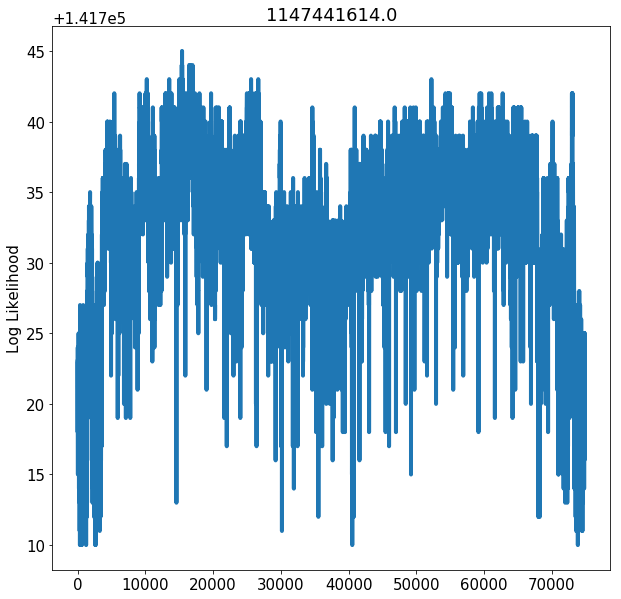

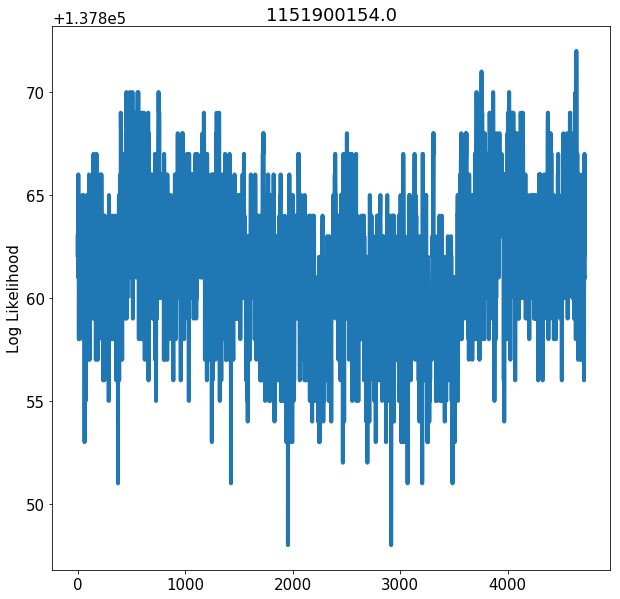

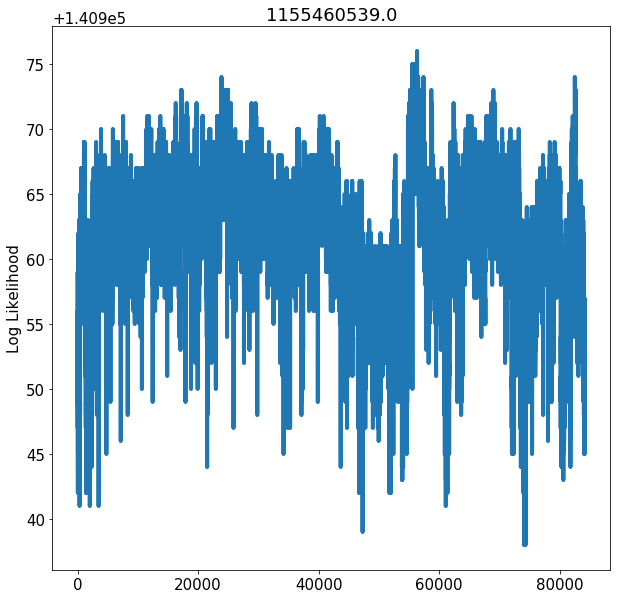

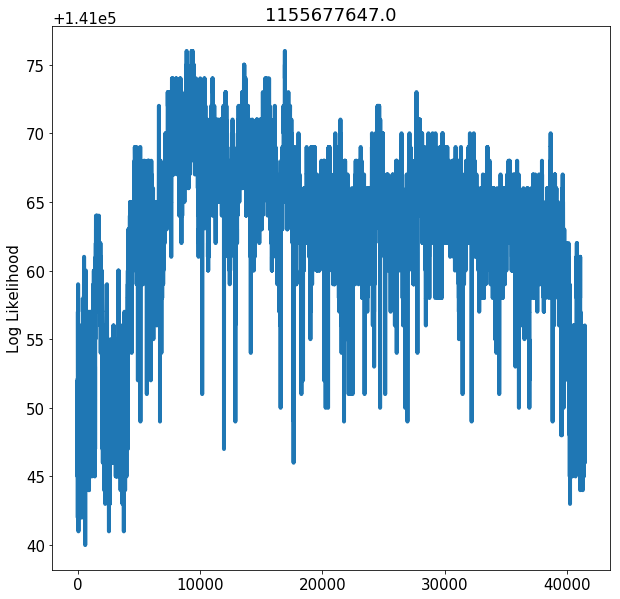

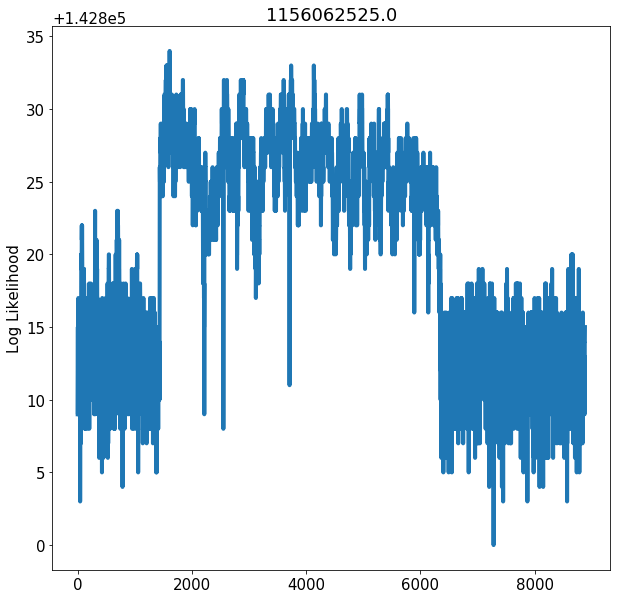

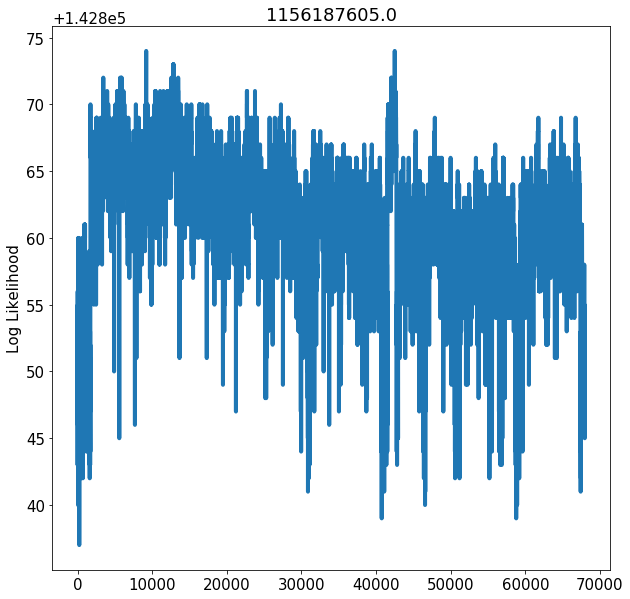

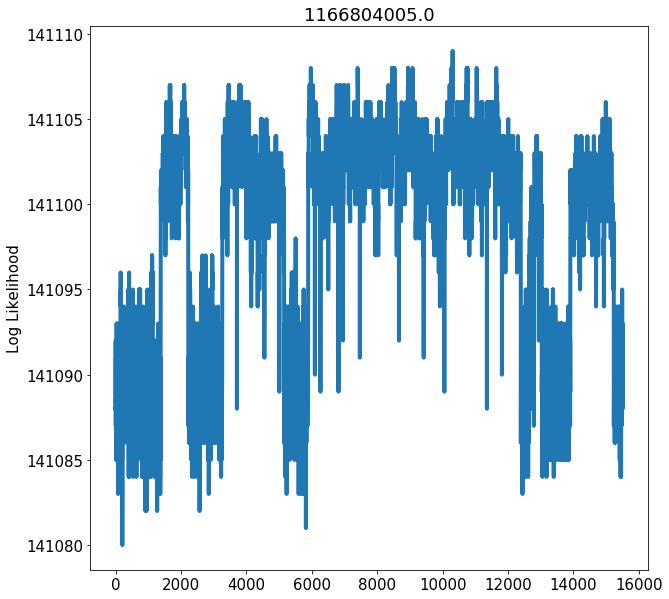

In [10]:
# Some of these chains are short? I am not sure what to do about it 
# These short chains are the marginal detections john found as maybe interesting
# After looking at the telemetry they seem OK but the problem is that the chains are too short to really see 
# anything

for impact1 in impactList.impact_list:
    # Log likelihood chain to see mixing
    
    if len(impact1.lon) < 200000:
        print('short', impact1.gps, impact1.run) 
        print('\t dfrac', impact1.dfrac)
    elif len(impact1.lon) > 500000:
        print('long', impact1.gps)
    else:
        #print('good', impact1.gps)
        #print('\t', impact1.dfrac)
        continue
    fig, ax = plt.subplots(figsize = (10,10))
    ax.set_ylabel("Log Likelihood")
    ax.plot(impact1.logL)
    ax.set_title(impact1.segment)



### Segment List
I am genuinely unsure how to handle the glitches that jake vetoed, but here is a list of all the segments together along with their command. This is mostly relevant for the bayesian analysis but it might still be relevant here. 

I tried to includes the times when both were running but it was more difficult than expected and I ran out of time. 

In [11]:
regex = r'.*g_(\d+)_(\d+).tar.gz'
timeDir = BASE_DIR + '/data/observed_times'
filenames = ['DRSlistDec.txt', 'LTPCMNTlist.txt', 'LTPlist2.txt']
write_file = open('segment_list_NEW.txt', 'w+')
write_file.write('segment\tlength\tcontrol\n')

class seg:
    def __init__(self, segment, length, command):
        self.segment = segment
        self.length = length
        self.command = command
        return

segs = []
for files in filenames:
    t_file = timeDir +'/' + files
    with open(t_file) as f:
        content = f.readlines()
        
    if files == 'DRSlistDec.txt':
        command = 'DRS'
    elif files == 'LTPCMNTlist.txt':
        command = 'BOTH'
    else:
        command = 'LTP'
            
    t0s = [int(re.findall(regex, c)[0][0]) for c in content]
    seg_len = [int(re.findall(regex, c)[0][1]) for c in content]
    
    for i in range(len(t0s)):
        segs.append(seg(t0s[i], seg_len[i], command))
            
    for i in range(len(t0s)):
        write_file.write('%i\t%i\t%s\n'%(t0s[i], seg_len[i], command))
write_file.close()

In [81]:
def getObservedTime(segment, dt = 0):
    #dt is time from start of segment
    searchTimes = getSearchTimes()
    searchTimes = searchTimes.sort_values('segment').reset_index()
    searchTimes['total'] = searchTimes.length.cumsum()
    
    line = searchTimes.loc[searchTimes['segment'] == segment]
    return line['total'].values[0]

for impact0 in impactList.impact_list:
    print(getObservedTime(impact0.segment, impact0.gps - impact0.segment))
    

1362816
2245698
2493036
2504502
2717442
2764944
3441438
3909906
4158379
4380535
4714687
4893229
5388957
6016300
6216774
6373522
6452785
6519444
6675513
6749223
6839313
6940221
7088703
7229571
8337535
9073778
9145850
9206456
9363704
9914072
9981230
10285898
10402196
10474268
10782212
11085242
11126192
11412842
11527502
11732252
11815790
11846912
12095888
12886043
12889319
13136657
13213643
13297181
13374167
13426583
13705043
14026091
14664911
15212003


### LaTex Table
Creates a copy and pasteable table for LaTex documents

In [12]:
# Make Summary table
# Make sure \usepackage{longtable} is at the beginning of the doc
lateX_file = open(BASE_DIR + dataDir + '/lateX_table.tec', 'w+')
summary_table = impactList.summaryTable(percent_sky = 0.1)
lateX_file.write(summary_table)
lateX_file.close()
print(summary_table)



		\begingroup
		\renewcommand\arraystretch{2}
		\begin{longtable}{|c|c|c|c|c|c|c|c|c|}
			\multicolumn{9}{c}
			{{\bfseries \tablename\  \thetable{}}}\\
			\hline \multicolumn{1}{|c}{\textbf{Date}} & 
			\multicolumn{1}{|c|}{\textbf{GPS}}  & 
			\multicolumn{1}{|c|}{\bf{$\rho_{med}$ [$\mu Ns$]}} & 
			\multicolumn{1}{|c|}{\textbf{Face}} &
			\multicolumn{1}{|c|}{\textbf{Sky Area}} &
			\multicolumn{1}{|c|}{\textbf{$Lat_{SC}$}} &
			\multicolumn{1}{|c|}{\textbf{$Lon_{SC}$}} &
			\multicolumn{1}{|c|}{\textbf{$Lat_{sun}$}} &
			\multicolumn{1}{|c|}{\textbf{$Lon_{sun}$}} \\
			\hline
		\endfirsthead
		
		\multicolumn{9}{c}
			{{\bfseries \tablename\  \thetable{} -- continued from previous page}} \\
		\hline \multicolumn{1}{|c|}{\textbf{Date}} & 
			\multicolumn{1}{|c|}{\textbf{GPS}}  & 
			\multicolumn{1}{|c|}{\bf{$\rho_{med}$ [$\mu Ns$]}} & 
			\multicolumn{1}{|c|}{\textbf{Face}} &
			\multicolumn{1}{|c|}{\textbf{Sky Area}} &
			\multicolumn{1}{|c|}{\textbf{$Lat_{SC}$}} &
			\multicolumn

We can also just get one line from the summary table if we'd like

In [13]:
impactList.impact_list[0].summaryString()

'2016-04-09 & 1144229908 & $17.2^{+0.4}_{-0.3}$ & +y+y & 1729 & -7 & -7 & -40 & -98 \\\\'